In [1]:
!pip install pandas matplotlib scikit-learn

Silhouette Score: 0.512
Modes for categorical features in each cluster (original labels):
   cluster product_category_name_english customer_state
0        0                bed_bath_table             SP
1        1              office_furniture             SP
2        2                bed_bath_table             RJ

Adjusted Cluster Centers with Modes (including original labels):
   total cost        volume  product_weight_g  time_cost  \
0  104.890227  10044.342650       1248.606163   8.786267   
1  461.827778  72976.463753      11517.885025  13.561582   
2  128.545234  11337.727247       1542.465071  27.721025   

  product_category_name_english customer_state  
0                bed_bath_table             SP  
1              office_furniture             SP  
2                bed_bath_table             RJ  


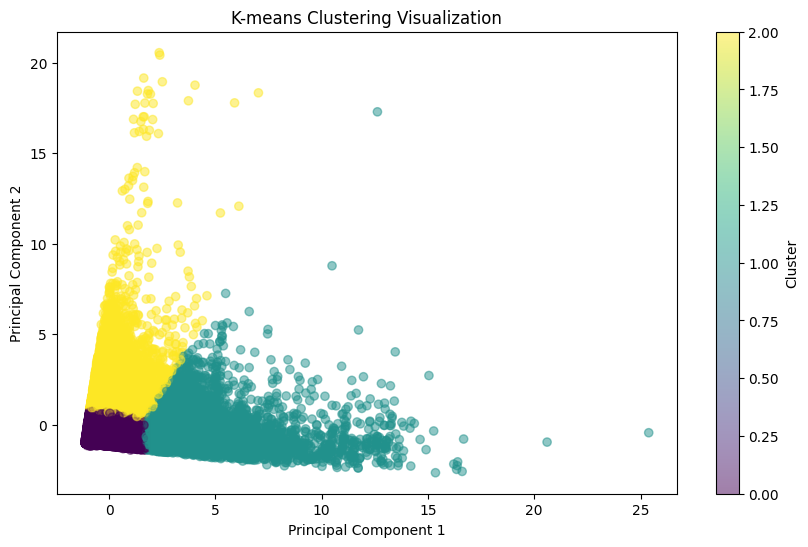

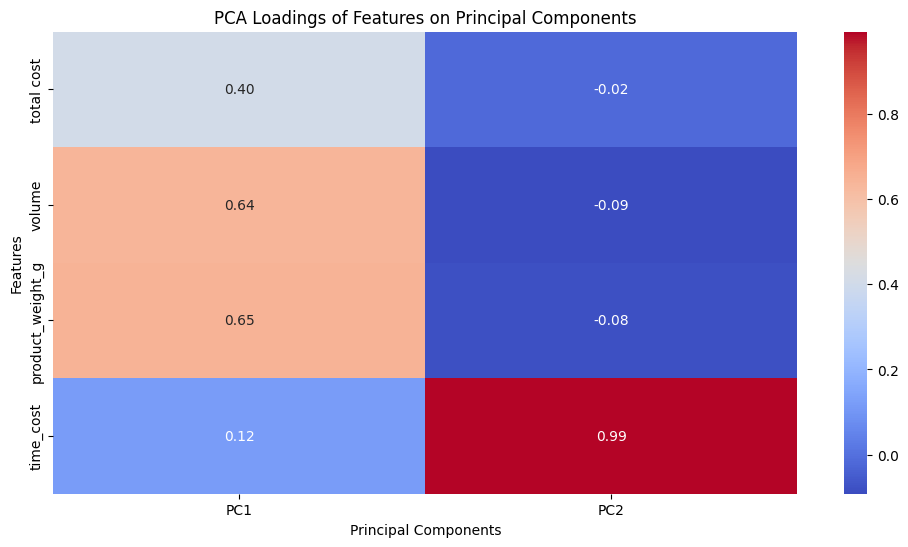

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Load the dataset
unsupervised = pd.read_csv('/content/unsupervised.csv')
data = unsupervised.copy()

# Initialize and fit LabelEncoders for categorical variables
label_encoder_product = LabelEncoder()
label_encoder_state = LabelEncoder()
data['product_category_name_english'] = label_encoder_product.fit_transform(data['product_category_name_english'])
data['customer_state'] = label_encoder_state.fit_transform(data['customer_state'])

# Identify numerical columns (excluding categorical and non-scaled columns)
numerical_columns = data.select_dtypes(include=[np.number]).columns.drop(['product_category_name_english', 'customer_state'])

# Scale numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_columns])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2) 
principal_components = pca.fit_transform(scaled_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(principal_components)

# Add cluster labels to the original dataframe
data['cluster'] = clusters

# Calculate and print the silhouette score
silhouette_avg = silhouette_score(principal_components, clusters)
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Calculate mode for categorical variables in each cluster
modes = data.groupby('cluster')[['product_category_name_english', 'customer_state']].agg(pd.Series.mode)
modes = modes.reset_index()

# Translate modes back to original labels
modes['product_category_name_english'] = label_encoder_product.inverse_transform(modes['product_category_name_english'])
modes['customer_state'] = label_encoder_state.inverse_transform(modes['customer_state'])

# Print the modes with original labels
print("Modes for categorical features in each cluster (original labels):")
print(modes)

# Combine the mode data with the continuous variable cluster centers
cluster_centers_original_space = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
cluster_centers_df = pd.DataFrame(cluster_centers_original_space, columns=numerical_columns)

# Combine the mode with cluster centers
final_cluster_centers = pd.concat([cluster_centers_df, modes.drop('cluster', axis=1)], axis=1)
print("\nAdjusted Cluster Centers with Modes (including original labels):")
print(final_cluster_centers)

# Plot the clusters using PCA-transformed components
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Get the PCA components
components = pca.components_
feature_names = data[numerical_columns].columns
components_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=feature_names)

# Plot heatmap of PCA loadings
plt.figure(figsize=(12, 6))
sns.heatmap(components_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Loadings of Features on Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

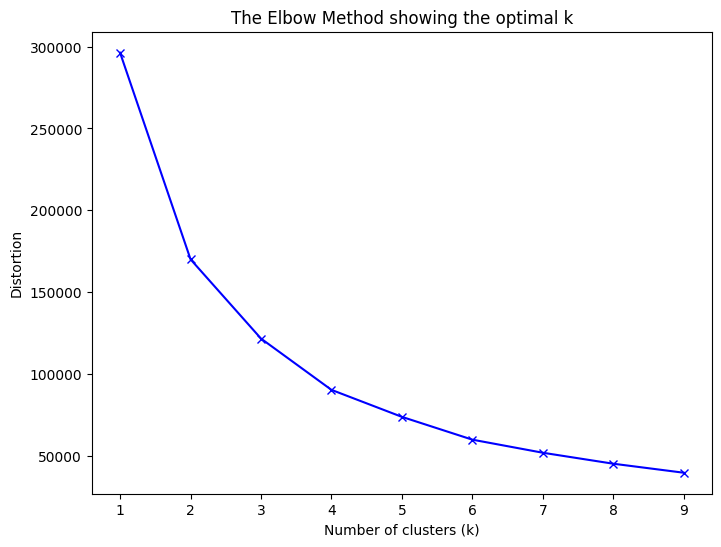

In [26]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(principal_components)
    distortions.append(kmeanModel.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()